# Notebook containing the figures

In [44]:
import torch
import matplotlib.pyplot as plt 
import os
import datetime
import pandas as pd
from matplotlib.ticker import AutoMinorLocator
import json
FOLDER = 'figures'
SIMULATION_FOLDER = 'simulations'
GRAPHS_ID = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
graph_folder = os.path.join(FOLDER, GRAPHS_ID)
os.makedirs(graph_folder, exist_ok=True)

## Functions used for positive and negative updates

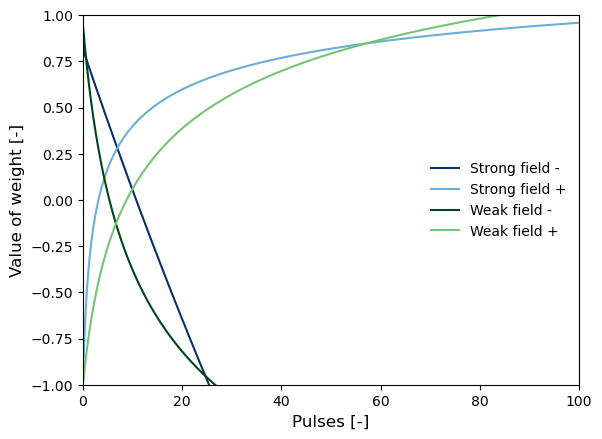

In [45]:
scale = 1
f_strong_minus = lambda x: scale * (2*(-24.77 * \
                torch.log(0.287*torch.log(x+128))+9.11)-1)
f_strong_plus = lambda x: scale * (2*(0.443 * \
                torch.log(2.53*torch.log(x+1.66)) - 0.11)-1)

f_weak_minus = lambda x: scale * \
                (-2.56*torch.log(0.997*torch.log(x+5.02)) + 2.166)
f_weak_plus = lambda x: scale * \
                (1.8132 * torch.log(1.176*torch.log(x+4.42))-2.014)
# plot all functions
fig, ax = plt.subplots()
x = torch.linspace(0, 100, 1000)
shades_blue = plt.get_cmap('Blues_r', 3)
shades_green = plt.get_cmap('Greens_r', 3)
ax.plot(x, f_strong_minus(x), label="Strong field -", color=shades_blue(0))
ax.plot(x, f_strong_plus(x), label="Strong field +", color=shades_blue(1))
ax.plot(x, f_weak_minus(x), label="Weak field -", color=shades_green(0))
ax.plot(x, f_weak_plus(x), label="Weak field +", color=shades_green(1))
ax.legend(loc='center right', fontsize=10, frameon=False)
ax.set_xlabel("Pulses [-]", fontsize=12)
ax.set_ylabel("Value of weight [-]", fontsize=12)
# export
name = "weight-evolution-" + GRAPHS_ID
ax.set_ylim(-scale, scale)
ax.set_xlim(0, 100)
fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')
fig.savefig(f"{graph_folder}/{name}.svg", bbox_inches='tight')

## Load dataframe from simulation

In [46]:
n_iterations = 10
# Create a pandas dataframe with columns type, mean, std, learning rate
df = pd.DataFrame()
# get all paths
paths = [f for f in os.listdir(SIMULATION_FOLDER) if os.path.isdir(os.path.join(SIMULATION_FOLDER, f))]
for k, path in enumerate(paths):
    try:
        # first dim of the tensor is the iteration
        accuracies = []
        mean_abs_grad = []
        swap = []
        weights = ""
        for it in range(n_iterations):
            jfile = path+f"-{it}.json"
            current_folder = os.path.join(SIMULATION_FOLDER, path)
            accuracies.append(torch.load(os.path.join(current_folder, path+f"-{it}-accuracies.pth")))
            mean_abs_grad.append(torch.load(os.path.join(current_folder, path+f"-{it}-gradients.pth")))
            swap_dict = json.load(open(os.path.join(current_folder, jfile), "r"))
            swap.append(swap_dict["swap_accuracy"])
            if it == 0:
                weights = os.path.join(current_folder, path+f"-{it}.pth")
                parameters = json.load(open(os.path.join(current_folder, jfile), "r"))
        accuracies = torch.stack(accuracies)    
        mean = accuracies.mean(dim=0)[-1].item()*100
        std = accuracies.std(dim=0)[-1].item()*100
        mean_abs_grad = torch.stack(mean_abs_grad).mean(dim=0)[0].item()
        swap_mean = torch.tensor(swap).mean().item()
        swap_std = torch.tensor(swap).std().item()
        # print parameters but well formatted
        task = parameters["task"]
        n_devices = parameters["optimizer_parameters"]["field"][0].split("-")[0]
        type_devices = parameters["optimizer_parameters"]["field"][0].split("-")[1]
        learning_rate = float(parameters["optimizer_parameters"]["lr"])
        scale = parameters["optimizer_parameters"]["scale"]
        resistor_noise = parameters["resistor_noise"]
        voltage_noise = parameters["voltage_noise"]
        var = parameters["optimizer_parameters"]["device_variability"]
        clipping = parameters["optimizer_parameters"]["clipping"]
        input_scale = parameters["input_scale"]
        records = pd.DataFrame.from_records([{"task": task,
                        "type_devices": type_devices,
                        "n_devices": n_devices,
                        "learning_rate": learning_rate,
                        "weights_path": weights,
                        "mean": mean,
                        "std": std,
                        "scale": scale,
                        "resistor_noise": resistor_noise,
                        "voltage_noise": voltage_noise,
                        "mean_abs_grad": mean_abs_grad,
                        "var": var,
                        "clipping": clipping,
                        "input_scale": input_scale,
                        "swap_mean": swap_mean,
                        "swap_std": swap_std}], index=[k])
        df = pd.concat([df, records])
    except Exception as e:
        print(e)
        pass
df

[Errno 2] No such file or directory: 'simulations/20240726190847-MNIST-double-linear-3000.0-var-0.2-clipping-0.1-resistor-0.015-voltage-1.5e-06/20240726190847-MNIST-double-linear-3000.0-var-0.2-clipping-0.1-resistor-0.015-voltage-1.5e-06-1-accuracies.pth'


,task,type_devices,n_devices,learning_rate,weights_path,mean,std,scale,resistor_noise,voltage_noise,mean_abs_grad,var,clipping,input_scale,swap_mean,swap_std
0,MNIST,linear,double,500.0,simulations/20240731091209-MNIST-double-linear...,96.748000,0.089912,1,0.015,0.000002,0.017207,0.2,0.0,0.001,96.540993,0.065566
1,MNIST,linear,double,500.0,simulations/20240725171818-MNIST-double-linear...,97.397995,0.034256,1,0.000,0.000000,0.016746,0.0,0.0,0.001,97.124001,0.071368
2,MNIST,linear,double,1000.0,simulations/20240725172042-MNIST-double-linear...,97.441006,0.043575,1,0.000,0.000000,0.029116,0.0,0.0,0.001,97.121002,0.053426
3,MNIST,linear,double,2000.0,simulations/20240725172306-MNIST-double-linear...,97.364008,0.043256,1,0.000,0.000000,0.048619,0.0,0.0,0.001,96.942001,0.073607
4,MNIST,linear,double,3000.0,simulations/20240725172529-MNIST-double-linear...,97.215003,0.040069,1,0.000,0.000000,0.064785,0.0,0.0,0.001,96.665009,0.075608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,MNIST,exponential,double,1000.0,simulations/20240827184326-MNIST-double-expone...,56.237996,11.704035,1,0.015,0.000002,0.020241,0.2,1.0,0.001,10.209000,0.505886
198,MNIST,exponential,double,2000.0,simulations/20240827184624-MNIST-double-expone...,89.675009,0.498893,1,0.015,0.000002,0.025077,0.2,1.0,0.001,10.246999,1.357997
199,MNIST,exponential,double,3000.0,simulations/20240827184925-MNIST-double-expone...,89.013994,0.793742,1,0.015,0.000002,0.050725,0.2,1.0,0.001,9.884000,0.350118
200,MNIST,exponential,double,4000.0,simulations/20240827185222-MNIST-double-expone...,88.891000,0.988156,1,0.015,0.000002,0.068593,0.2,1.0,0.001,10.588999,2.684774


## Accuracy vs learning rate

### Main figure

In [47]:
def plot_lr_vs_acc(resistor_noise, clipping, var, graph_id):
    for task in df["task"].unique():
        df_filtered = df[(df["task"] == task) & (df["resistor_noise"] == resistor_noise) & (df["clipping"] == clipping) & (df["var"] == var)].sort_values("learning_rate")
        fig, ax = plt.subplots()
        palette = plt.get_cmap('viridis', len(df["type_devices"].unique())+1)
        for i, (name, group) in enumerate(df_filtered.groupby("type_devices")):  
            if name == "linear":
                ax.plot(group["learning_rate"], group["swap_mean"], label="Field relaxation" , color=palette(i), marker='o', linestyle='--')
                ax.fill_between(group["learning_rate"], group["swap_mean"]-group["swap_std"], group["swap_mean"]+group["swap_std"], alpha=0.2, color=palette(i))
            ax.plot(group["learning_rate"], group["mean"], label=name, color=palette(i), marker='x')
            ax.fill_between(group["learning_rate"], group["mean"]-group["std"], group["mean"]+group["std"], alpha=0.2, color=palette(i))
        ax.set_xlabel("Learning rate [-]", fontsize=12)
        ax.set_ylabel("Test accuracy [%]", fontsize=12)
        ax.legend(loc='lower right', fontsize=10, frameon=False)
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        offset = 5
        minimum = 90 if task == "MNIST" else 80
        maximum = min(100, df_filtered["mean"].max() + offset)
        ax.set_ylim([minimum, maximum])
        ax.set_ylim([minimum, maximum])
        plt.show()
    # save as pdf and svg
        name = f"learning-rate-{task}-resistor_noise-{resistor_noise}-var-{var}-{graph_id}"
        fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')

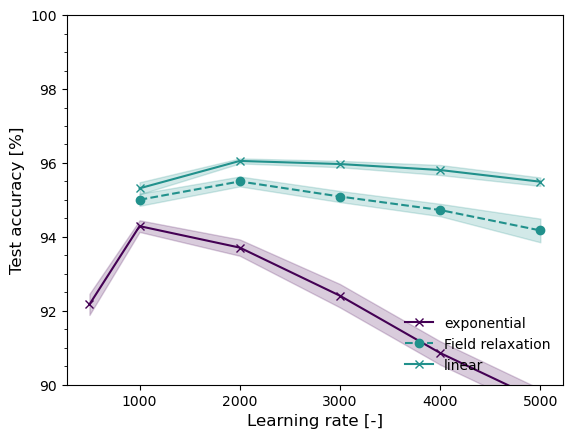

In [60]:
# for each task, plot the evolution of the accuracy
resistor_noise = 0.015
clipping = 0.1
var = 0.2
plot_lr_vs_acc(resistor_noise, clipping, var, GRAPHS_ID)

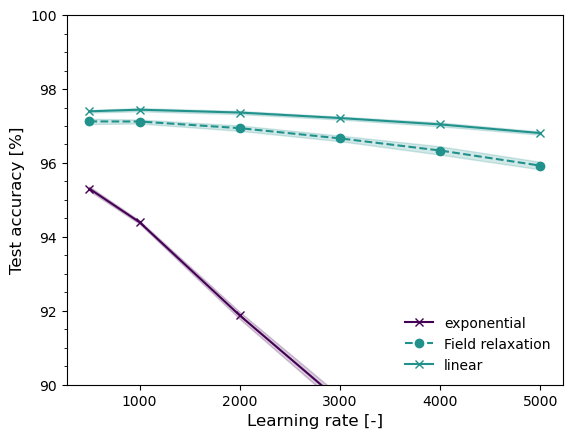

In [49]:
# for each task, plot the evolution of the accuracy
resistor_noise = 0.
clipping = 0
var = 0
plot_lr_vs_acc(resistor_noise, clipping, var, GRAPHS_ID)

### Supplementary figures

In [50]:
# # for each task, plot the evolution of the accuracy
# resistor_noise = 0
# clipping = [0.1, 0.2, 0.5]
# var = 0

# for task in df["task"].unique():
#     df_filtered = df[(df["task"] == task) & (df["resistor_noise"] == resistor_noise) & (df["clipping"] == clipping) & (df["var"] == var)].sort_values("learning_rate")
#     fig, ax = plt.subplots()
#     palette = plt.get_cmap('viridis', len(df["type_devices"].unique())+1)
#     for i, (name, group) in enumerate(df_filtered.groupby("type_devices")):  
#         if name == "linear":
#             ax.plot(group["learning_rate"], group["swap_mean"], label="Field relaxation" , color=palette(i), marker='o', linestyle='--')
#             ax.fill_between(group["learning_rate"], group["swap_mean"]-group["swap_std"], group["swap_mean"]+group["swap_std"], alpha=0.2, color=palette(i))
#         ax.plot(group["learning_rate"], group["mean"], label=name, color=palette(i), marker='x')
#         ax.fill_between(group["learning_rate"], group["mean"]-group["std"], group["mean"]+group["std"], alpha=0.2, color=palette(i))
#     ax.set_xlabel("Learning rate [-]", fontsize=12)
#     ax.set_ylabel("Test accuracy [%]", fontsize=12)
#     ax.legend(loc='lower right', fontsize=10, frameon=False)
#     ax.yaxis.set_minor_locator(AutoMinorLocator())
#     offset = 5
#     minimum = 90 if task == "MNIST" else 80
#     maximum = min(100, df_filtered["mean"].max() + offset)
#     ax.set_ylim([minimum, maximum])
#     ax.set_ylim([minimum, maximum])
#     plt.show()
# # save as pdf and svg
#     name = f"learning-rate-{task}-resistor_noise-{resistor_noise}-var-{var}-{graph_id}"
#     fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')

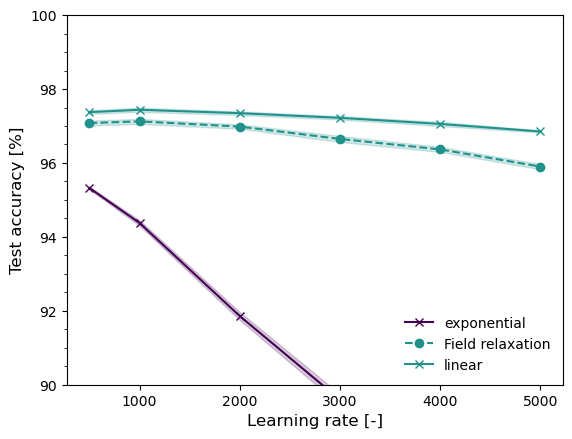

In [51]:
# for each task, plot the evolution of the accuracy
resistor_noise = 0.0015
clipping = 0.0
var = 0
plot_lr_vs_acc(resistor_noise, clipping, var, GRAPHS_ID)

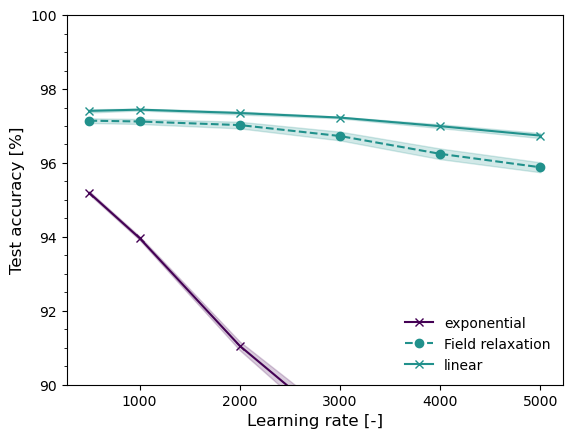

In [52]:
# for each task, plot the evolution of the accuracy
resistor_noise = 0.15
clipping = 0.0
var = 0
plot_lr_vs_acc(resistor_noise, clipping, var, GRAPHS_ID)

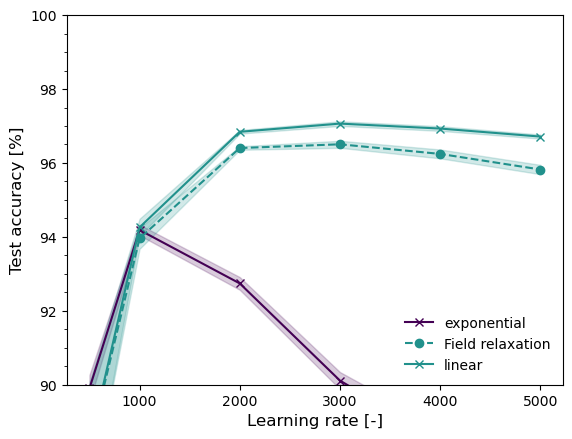

In [53]:
# for each task, plot the evolution of the accuracy
resistor_noise = 0
clipping = 0.2
var = 0
plot_lr_vs_acc(resistor_noise, clipping, var, GRAPHS_ID)

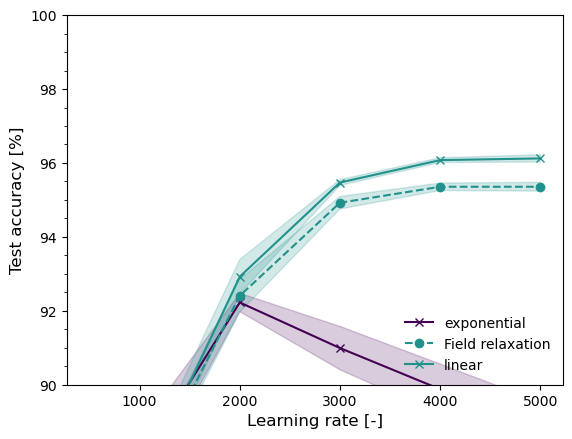

In [54]:
# for each task, plot the evolution of the accuracy
resistor_noise = 0
clipping = 0.5
var = 0
plot_lr_vs_acc(resistor_noise, clipping, var, GRAPHS_ID)

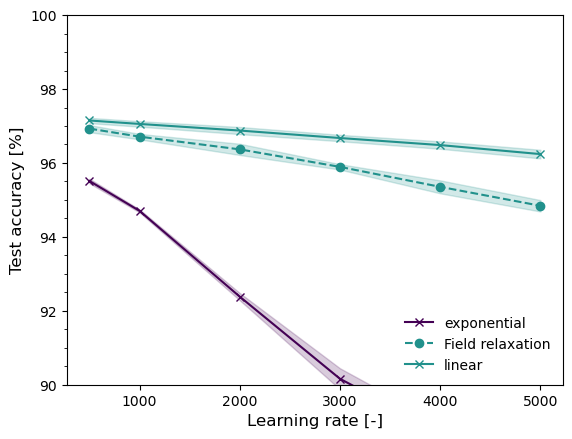

In [55]:
# for each task, plot the evolution of the accuracy
resistor_noise = 0
clipping = 0
var = 0.1
plot_lr_vs_acc(resistor_noise, clipping, var, GRAPHS_ID)

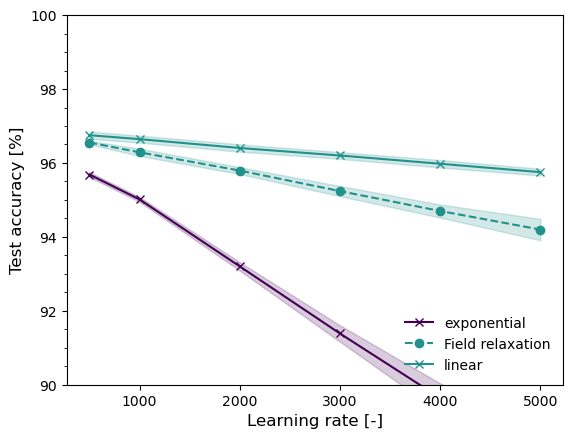

In [56]:
# for each task, plot the evolution of the accuracy
resistor_noise = 0
clipping = 0
var = 0.2
plot_lr_vs_acc(resistor_noise, clipping, var, GRAPHS_ID)

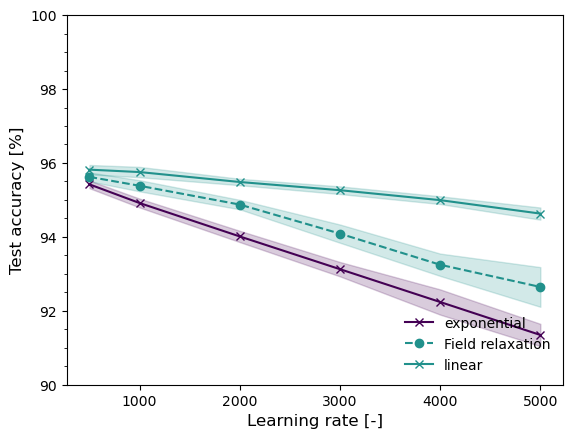

In [57]:
# for each task, plot the evolution of the accuracy
resistor_noise = 0
clipping = 0
var = 0.5
plot_lr_vs_acc(resistor_noise, clipping, var, GRAPHS_ID)

## Weights

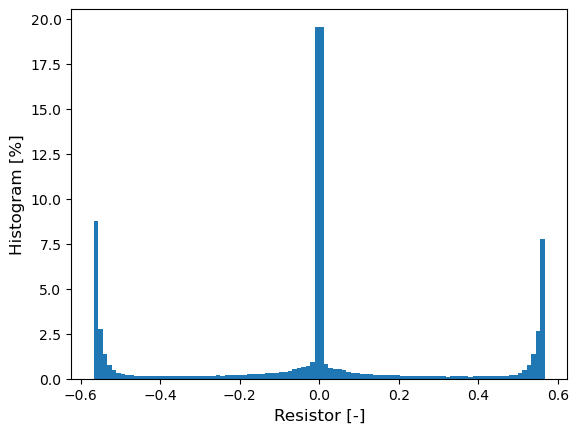

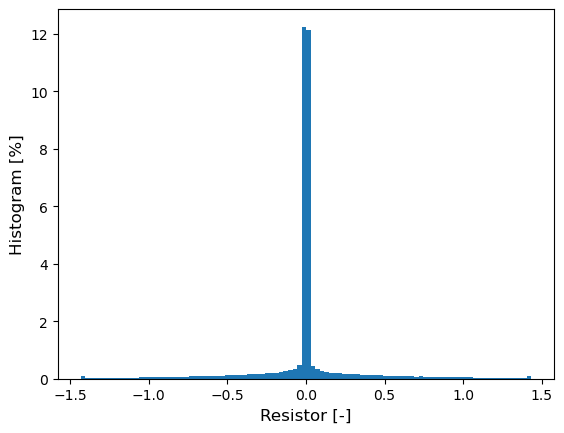

In [58]:
# we are going to plot te weights
resistor_noise = 0.015
clipping = 0.1
var = 0.2
for type_device in df["type_devices"].unique():
    df_filtered = df[(df["resistor_noise"] == resistor_noise) & (df["clipping"] == clipping) & (df["var"] == var) & (df["type_devices"] == type_device)].sort_values("mean", ascending=False)
    row = df_filtered.iloc[0]
    # load weights (ordered dict)
    weights = torch.load(row["weights_path"])
    # retrieve only the keys we are interested in
    layers_1_weight = weights["layers.1.weight2"] - weights["layers.1.weight1"]
    layers_4_weight = weights["layers.4.weight2"] - weights["layers.4.weight1"]
    
    # flatten the weights
    layers_1_weight = layers_1_weight.flatten()
    layers_4_weight = layers_4_weight.flatten()
    # merge the weights
    weights = torch.cat([layers_1_weight, layers_4_weight]).cpu().numpy()
    # histogram
    fig, ax = plt.subplots()
    ax.hist(weights, bins=100, density=True)
    ax.set_xlabel("Resistor [-]", fontsize=12)
    ax.set_ylabel("Histogram [%]", fontsize=12)
    # save as pdf and svg
    name = f"weights-{type_device}-{row['task']}-{row['mean']}-{GRAPHS_ID}"
    fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')
    

    